![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales/auto-ml-forecasting-orange-juice-sales.png)

# Homework
In this example, we use AutoML to train, select, and operationalize a time-series forecasting model for multiple time-series.

Make sure you have executed the [configuration notebook](../../../configuration.ipynb) before running this notebook.

## Setup

In [1]:
import azureml.core
import pandas as pd
import numpy as np
import logging

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.automl.core.featurization import FeaturizationConfig

This sample notebook may use features that are not available in previous versions of the Azure ML SDK.

In [2]:
print("This notebook was created using version 1.28.0 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.28.0 of the Azure ML SDK
You are currently using version 1.28.0 of the Azure ML SDK


As part of the setup you have already created a <b>Workspace</b>. To run AutoML, you also need to create an <b>Experiment</b>. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem. 

In [3]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'pax-forecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

/anaconda/envs/azureml_py36_automl/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  from ipykernel import kernelapp as app


,
Subscription ID,29e67936-a2a9-4c54-9dd6-26ef6c8c59e2
Workspace,timeseries-ws
SKU,Basic
Resource Group,timeseries-course
Location,southcentralus
Run History Name,pax-forecasting


## Compute
You will need to create a [compute target](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute) for your AutoML run. In this tutorial, you create AmlCompute as your training compute resource.

> Note that if you have an AzureML Data Scientist role, you will not have permission to create compute resources. Talk to your workspace or IT admin to create the compute targets described in this section, if they do not already exist.

#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
amlcompute_cluster_name = "automl-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=2)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


# Data Load 
* Let's load interstate traffic volumes along with some descriptive variables of weather 
* Let’s drop duplicates, as the same hour has different weather conditions.


In [5]:
df = pd.read_csv(r'../../data/Metro_Interstate_Traffic_Volume.csv')
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)
df = df.sort_values('date_time')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


## Data Splitting
We now split the data into a training and a testing set for later forecast evaluation. The test set will contain the final 8,000 observiations. 

In [6]:
n = 8000
train = df.iloc[:-n]
test = df.iloc[-n:]
train

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
36840,None,290.22,0.0,0.0,90,Clouds,overcast clouds,2017-09-02 07:00:00,2235
36843,None,290.72,0.0,0.0,90,Clouds,overcast clouds,2017-09-02 09:00:00,3854
36844,None,291.48,0.0,0.0,90,Mist,mist,2017-09-02 10:00:00,4519
36845,None,292.68,0.0,0.0,75,Clouds,broken clouds,2017-09-02 11:00:00,4720


# Problem 1: `Upload data to datastore`
The [Machine Learning service workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-workspace), is paired with the storage account, which contains the default data store. We will use it to upload the train and test data and create [tabular datasets](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset?view=azure-ml-py) for training and testing. A tabular dataset defines a series of lazily-evaluated, immutable operations to load data from the data source into tabular representation.

* Write `train` & `test` to local CSVs
* Use the default datastore's `upload_files` method to upload them to Azure

In [ ]:
# code here

In [8]:
# don't delete this cell, but try to reproduce it's output

Uploading an estimated of 2 files
Uploading ./traffic_train.csv
Uploaded ./traffic_train.csv, 1 files out of an estimated total of 2
Uploading ./traffic_test.csv
Uploaded ./traffic_test.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_6ca8521b04874b76a1f80110c57195fd

# Problem 2:  `Create dataset for training`

* Instanitate a Tabular `azureml.core.dataset.Dataset` by using the `from_delimited_files` to load the training CSV from the default datastore
* Print the tail of that tabular dataset

In [ ]:
# code here

In [9]:
# don't delete this cell, but try to reproduce it's output

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
27125,None,290.22,0.0,0.0,90,Clouds,overcast clouds,2017-09-02 07:00:00,2235
27126,None,290.72,0.0,0.0,90,Clouds,overcast clouds,2017-09-02 09:00:00,3854
27127,None,291.48,0.0,0.0,90,Mist,mist,2017-09-02 10:00:00,4519
27128,None,292.68,0.0,0.0,75,Clouds,broken clouds,2017-09-02 11:00:00,4720
27129,None,295.01,0.0,0.0,40,Haze,haze,2017-09-02 12:00:00,4840


# Problem 3: `Define target & time columns`

The 2 key columns for AutoML are the time and target columns

1. `time_column_name`: Initialize a simply python variable with this name & set's value to the appropriate column name in our dataset
1. `target_column_name`: Initialize a simply python variable with this name & set's value to the appropriate column name in our dataset

In [11]:
#code here

# Problem 4: `Forecasting Parameters`
To define forecasting parameters for your experiment training, you can leverage the ForecastingParameters class. The table below details the forecasting parameter we will be passing into our experiment.


|Property|Description|
|-|-|
|**time_column_name**|The name of your time column.|
|**forecast_horizon**|The forecast horizon is how many periods forward you would like to forecast. This integer horizon is in units of the timeseries frequency (e.g. daily, weekly).|
|**time_series_id_column_names**|The column names used to uniquely identify the time series in data that has multiple rows with the same timestamp. If the time series identifiers are not defined, the data set is assumed to be one time series.|
|**freq**|Forecast frequency. This optional parameter represents the period with which the forecast is desired, for example, daily, weekly, yearly, etc. Use this parameter for the correction of time series containing irregular data points or for padding of short time series. The frequency needs to be a pandas offset alias. Please refer to [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) for more information.

* Set the forecasting parameter of `time_column_name` to time_column_name
* Set the forecasting parameter of `forecast_horizon` to 24
* Set the forecasting parameter of `freq` to the appropriate pandas offset alias

In [13]:
# code here

# Problem 5: `AutoMLConfig`

Instantiate a `AutoMLConfig` object with the appropriate parameters:

* `primary_metric`
* `training_data`
* `label_column_name`
* `compute_target` : the compute_target we created above
* `forecasting_parameters`: the forecasting_parameters we created above

In [14]:
# code here

# Problem 6: `Submit Training Run`

You can now submit a new training run. Depending on the data and number of iterations this operation may take several minutes.
Information from each iteration will be printed to the console.  Validation errors and current status will be shown when setting `show_output=True` and the execution will be synchronous.

In [ ]:
# code here

In [45]:
# don't delete this cell, but try to reproduce it's output

Submitting remote run.
Running on remote compute: automl-cluster


Experiment,Id,Type,Status,Details Page,Docs Page
pax-forecasting,AutoML_483be5be-11d8-4399-8ec6-bad0a60a995e,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Short series handling
STATUS:       PASSED
DESCRIPTION:  Automated ML detected enough data points for each series in the input data to continue with training.
              

****************************************************************************************************

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing 

# Problem 7:  `Retrieve the Best Model`
Each run within an Experiment stores serialized (i.e. pickled) pipelines from the AutoML iterations. We can now retrieve the pipeline with the best performance on the validation dataset:

* Print the best model's steps in it's pipeline

In [ ]:
# code here

In [47]:
# don't delete this cell, but try to reproduce it's output

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


[('timeseriestransformer', TimeSeriesTransformer(
    pipeline_type=TimeSeriesPipelineType.FULL,
    max_horizon=24,
    use_stl=None,
    seasonality=24,
    force_time_index_features=None,
    grain_column_names=['_automl_dummy_grain_col'],
    drop_column_names=[],
    origin_time_colname='origin',
    group=None,
    country_or_region=None,
    freq='H',
    time_column_name='date_time',
    pipeline=Pipeline(
        memory=None,
        steps=[('make_numeric_na_dummies', MissingDummiesTransformer(
            numerical_columns=['temp', 'rain_1h', 'snow_1h', 'clouds_all']
        )), ('impute_na_numeric_datetime', TimeSeriesImputer(
            end=None,
            freq='H',
            impute_by_horizon=False,
            input_column=['temp', 'rain_1h', 'snow_1h', 'clouds_all'],
            limit=None,
            limit_direction='forward',
            method=OrderedDict([('ffill', [])]),
            option='fillna',
            order=None,
            origin=None,
            

# Problem 8:  `Transparency`

Print updated featurization summary

In [48]:
# code ehre

In [49]:
# don't delete this cell, but try to reproduce it's output

[{'RawFeatureName': 'holiday',
  'TypeDetected': 'Categorical',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['LabelEncoder']},
 {'RawFeatureName': 'temp',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'rain_1h',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'snow_1h',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'clouds_all',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'weather_main',
  'TypeDetected': 'Categorical',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['LabelEncoder']},
 {'

# Problem 9: `Forecasting Prep`

Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data.

* Remove the target values from the test set:

In [50]:
# code here

In [51]:
# don't delete this cell, but try to reproduce it's output

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
36847,None,296.34,0.00,0.00,75,Clouds,broken clouds,2017-09-02 13:00:00
36848,None,298.14,0.00,0.00,40,Clouds,scattered clouds,2017-09-02 14:00:00
36849,None,299.21,0.00,0.00,40,Clouds,scattered clouds,2017-09-02 15:00:00
36850,None,299.55,0.00,0.00,40,Clouds,scattered clouds,2017-09-02 16:00:00
36851,None,299.61,0.00,0.00,20,Clouds,few clouds,2017-09-02 17:00:00


# Problem 10: `Forecasting`

Use the fitted model to produce predictions for the test set

In [52]:
# code here

# Problem 11: `Evaluate`

To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE). For more metrics that can be used for evaluation after training, please see [supported metrics](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-understand-automated-ml#regressionforecasting-metrics), and [how to calculate residuals](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-understand-automated-ml#residuals).

We'll add predictions and actuals into a single dataframe for convenience in calculating the metrics.

* Display the test data scores
* Plot the prediction vs truth output on a chart

In [53]:
# code here

[Test data scores]

normalized_root_mean_squared_error:   0.121
median_absolute_error:   515.205
normalized_root_mean_squared_log_error:   nan
root_mean_squared_error:   851.693
r2_score:   0.815
root_mean_squared_log_error:   nan
normalized_median_absolute_error:   0.073
normalized_mean_absolute_error:   0.092
mean_absolute_error:   647.371
explained_variance:   0.832
mean_absolute_percentage_error:   46.217
spearman_correlation:   0.911


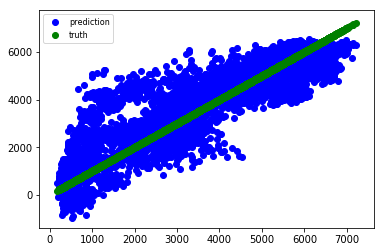

In [54]:
# don't delete this cell, but try to reproduce it's output

[Test data scores]

median_absolute_error:   4005.090
root_mean_squared_error:   18646.748
normalized_median_absolute_error:   0.030
r2_score:   0.178
explained_variance:   0.182
root_mean_squared_log_error:   0.733
normalized_root_mean_squared_error:   0.141
spearman_correlation:   0.637
normalized_mean_absolute_error:   0.078
normalized_root_mean_squared_log_error:   0.161
mean_absolute_percentage_error:   78.163
mean_absolute_error:   10287.466


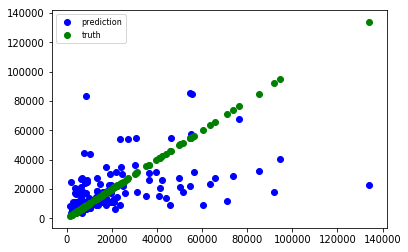

In [30]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module
scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

# Problem 12: `Operationalize`

_Operationalization_ means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.

* Use the `register_model` method on the `remote_run` to register this mode in our Azure ML workspace
* Print the `remote_run.model_id`

In [ ]:
# code here

In [55]:
# don't delete this cell, but try to reproduce it's output

AutoML483be5be11


# Problem 12: `Develop the scoring script`

For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.

* Define a variable called `script_file_name` with value the defined the name of our scoring .py file
* Use `download_file` from our `best_run` to download *'outputs/scoring_file_v_1_0_0.py'* into 

In [56]:
# code here

# Problem 13: `Deploy on Container Instance`

* Define an `InferenceConfig` object with an `entry_script` parameter that has a value equal to `script_file_name`
* Define an *Deployment Config* using `AciWebservice`'s `deploy_configuration` function
* **Deploy the Model**: Use the `Model.deploy` methods with the following parameters
    * `model` : our model
    * `inference_config` : our InferenceConfig we defined above
    * `aciconfig` the deployment config defined above
* Print the aci_service state

In [ ]:
# code here

In [57]:
# don't delete this cell, but try to reproduce it's output

traffic-forecast-01
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-05-17 18:08:38+00:00 Creating Container Registry if not exists.
2021-05-17 18:08:38+00:00 Registering the environment.
2021-05-17 18:08:39+00:00 Use the existing image.
2021-05-17 18:08:39+00:00 Generating deployment configuration.
2021-05-17 18:08:40+00:00 Submitting deployment to compute.
2021-05-17 18:08:43+00:00 Checking the status of deployment traffic-forecast-01..
2021-05-17 18:14:35+00:00 Checking the status of inference endpoint traffic-forecast-01.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
